In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from RateTraining import *
from RateTrainingGPU import RateTrainingGPU
from LIFTrainingGPU import *

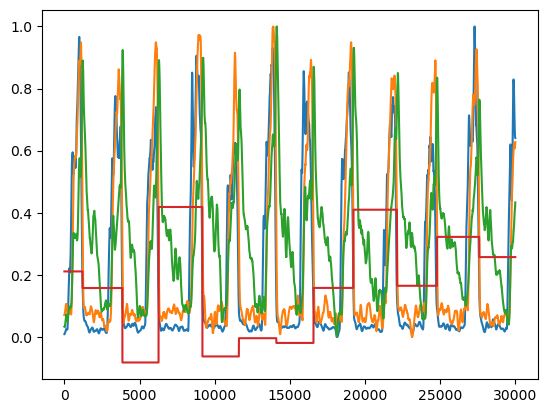

In [3]:
raw_waveforms = np.transpose(np.load("raw_form.npy"))
freqs = np.load("fin.npy")

fin = freqs[0:30000]
hfout = raw_waveforms[0][0:30000]
pfout = raw_waveforms[1][0:30000]
vfout = raw_waveforms[2][0:30000]

fout = np.vstack((hfout, pfout, vfout))

plt.plot(hfout)
plt.plot(pfout)
plt.plot(vfout)
plt.plot(fin)

In [4]:
rpars = create_default_params_rate()
rpars['net_size'] = 1500
rpars['total_time'] = 30000
rpars['runtime'] = 30000
rpars['stim_off'] = 50

In [5]:
uhfout = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), hfout)
upfout = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), pfout)
uvfout = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), vfout)

ufin = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), fin)

In [6]:
dnet = RateTrainingGPU(rpars)

In [7]:
stim = dnet.gen_rand_stim(rpars)

In [8]:
ufout = uhfout + upfout + uvfout
_, Hxd = dnet.run_rateGPU(ufout)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

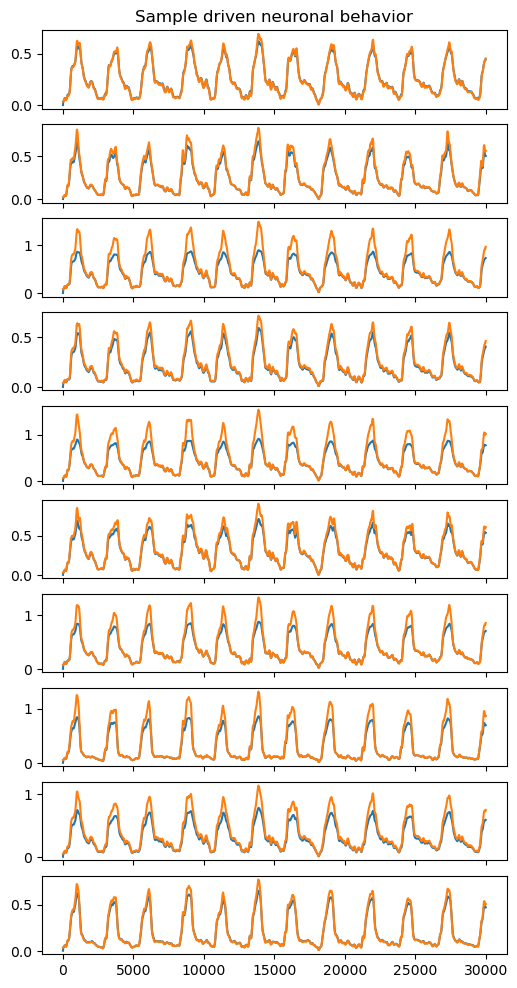

In [9]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    #axs[i].plot(stim[i])
    axs[i].plot(Hxd[i])
    axs[i].plot(ufout[i])

axs[0].set_title("Sample driven neuronal behavior")

In [10]:
gain = 1
# aux_targs = stim + Hxd * gain
aux_targs = Hxd * gain
np.shape(aux_targs)

(1500, 30000)

In [11]:
lifpars = create_default_params_LIF()

In [12]:
lifpars['net_size'] = 1500
lifpars['num_out'] = 3
lifpars['runtime'] = 30000
lifpars['total_time'] = 30000
lifpars['training_loops'] = 500

In [13]:
lifnet = LIFTrainingGPU(lifpars)

In [14]:
lifnet.trainGPU_LIF(ufin, aux_targs, fout)

training: 0
training: 100
training: 200
training: 300
training: 400


In [19]:
voltage, slow, fast = lifnet.run_LIF(ufin)

Text(0.5, 1.0, 'Behavior after training')

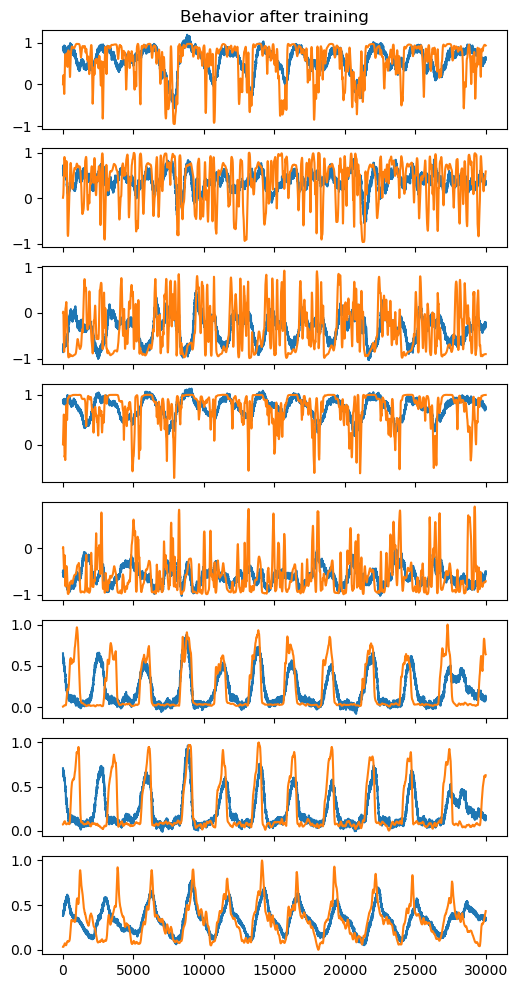

In [20]:
Jslow = np.dot(lifnet.Js, slow)
wout = np.dot(lifnet.W_out, slow)
n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot + 3, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslow[i])
    axs[i].plot(aux_targs[i][0:30000])
    # axs[i].vlines(lifnet.T, -0.25, 0.25)
for i in range(lifnet.num_outs):
    axs[n_plot + i].plot(wout[i])
    axs[n_plot + i].plot(fout[i, 0:30000])
    # axs[n_plot + i].vlines(lifnet.T, -0.25, 0.25)

axs[0].set_title("Behavior after training")

Text(0.5, 1.0, 'Fast synapses after training')

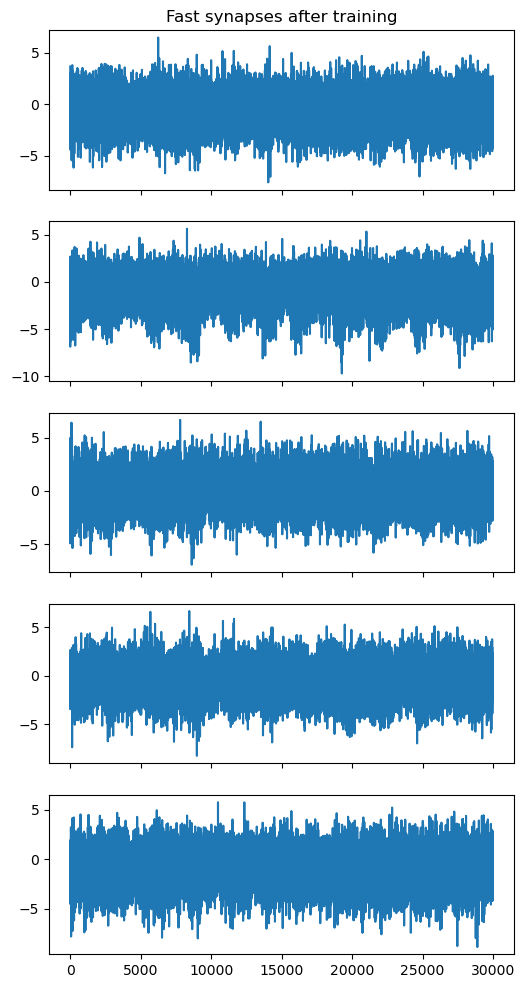

In [22]:
Jfast = np.dot(lifnet.Jf, fast)

n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jfast[i])
axs[0].set_title("Fast synapses after training")

Text(0.5, 1.0, 'Membrane potential (voltage) after training')

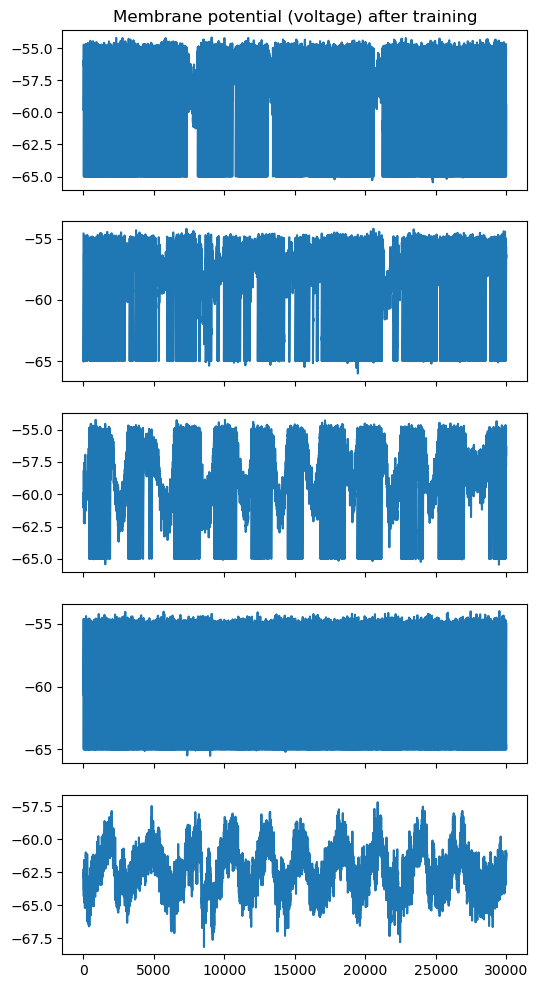

In [23]:
n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(voltage[i])
axs[0].set_title("Membrane potential (voltage) after training")

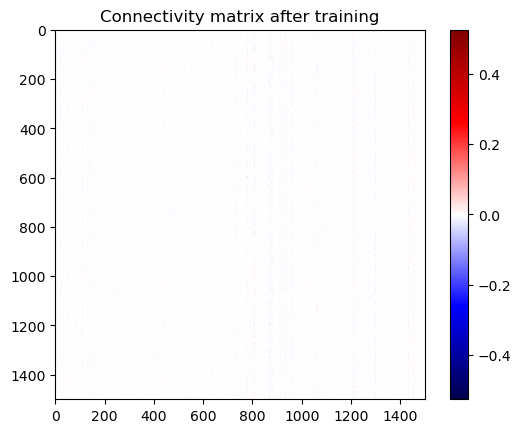

In [29]:
m = max(-1*np.min(lifnet.Js), np.max(lifnet.Js))

plt.imshow(lifnet.Js, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.title("Connectivity matrix after training")
plt.colorbar()

c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


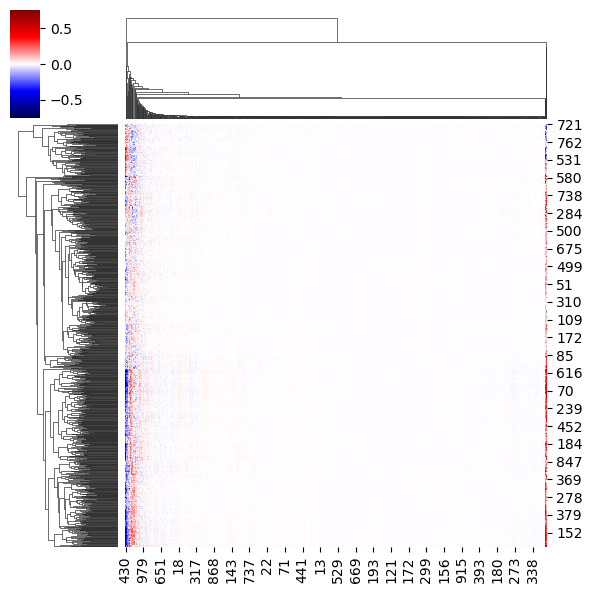

In [21]:
sns.clustermap(lifnet.Js, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m, figsize = (6, 6))


In [28]:
np.save("js1000", lifnet.Js)

In [29]:
np.save("auxtargs1000", aux_targs)

In [30]:
np.save("jf1000", lifnet.Jf)

In [33]:
np.save("wout1000", lifnet.W_out)